STRATEGY:
- Buy when:
 - SMA1 > SMA2 > SMA3 > SMA4
- Sell when:
 - (Sell ALL bought trades) Closing price is below SMA1

In [29]:
#!python3 -m pip install --upgrade pip

import pandas as pd
import ta
import matplotlib.pyplot as plt
import numpy as np

# Credentials

In [30]:
# keys_file = open("AllAccess_APICredentials.txt")
# lines = keys_file.readlines()
# api_key = lines[0].rstrip()
# api_secret = lines[1].rstrip()

# Opening Client

In [31]:
# import os
# import sys
# from bfxapi import Client, Order

# bfx = Client(
#   API_KEY=api_key,
#   API_SECRET=api_secret
# )

# Getting Historical Data

In [32]:
import time

input_time = "01 Jan 2011"
start_time = time.strptime(input_time, "%d %b %Y")
start_time = time.mktime(start_time)*1000

input_time = "01 Jan 2022"
end_time = time.strptime(input_time, "%d %b %Y")
end_time = time.mktime(end_time)*1000

In [33]:
# import json
# import time

# import requests

# timestamp = start_time
# last_timestamp = None
# time_diff = 0

# pair = 'tBTCUSD'

# # url = ('https://api-pub.bitfinex.com/v2/'
# #       f'candles/trade:1D:{pair}/hist')
# # historical_data = []

# # while (timestamp <= end_time):
# #     try:
# #         print("Requesting "+ time.ctime(timestamp/1000))
# #         params = {'start': timestamp, 'limit': 365, 'sort': 1}
# #         response = requests.get(url, params=params)
# #         trades = json.loads(response.content)

# #         time_diff = (trades[-1][0] - trades[-2][0])
# #         timestamp = (trades[-1][0]) + time_diff
        
# #         historical_data.extend(trades)
# #         time.sleep(5)
# #     except Exception as e:
# #         print('LAST REQUEST FAILED')
# #         print('LAST ENTRY: ', time.ctime(historical_data[-1][0]/1000))
# #         break
    

In [34]:
# columns = ['MTS', 'OPEN', 'CLOSE', 'HIGH', 'LOW', 'VOLUME']
# df_candles = pd.DataFrame(historical_data, columns=columns)

In [35]:
# df_candles.to_csv(f'{pair}_{time.ctime(historical_data[0][0]/1000)}'
#                   f'_to_{time.ctime(historical_data[-1][0]/1000)}.csv'
#                   .replace(' ', '_'),
#                  index=None
#                  )

# Opening Saved Historical Data for Analysis

In [36]:
#df_candles = pd.read_csv(f'{pair}_Sun_Mar_31_08:00:00_2013_to_Mon_May_17_08:00:00_2021.csv')[:]
df_candles = pd.read_csv(f'tBTCUSD_Sun_Mar_31_08:00:00_2013_to_Mon_May_17_08:00:00_2021.csv')[:]
df_candles

,MTS,OPEN,CLOSE,HIGH,LOW,VOLUME
0,1364688000000,92.500000,93.033000,93.74999,91.00000,3083.079791
1,1364774400000,93.250000,103.999000,105.90000,92.49999,5224.401313
2,1364860800000,104.000000,118.229354,118.38670,99.00000,8376.527478
3,1364947200000,117.958261,134.700000,146.88000,101.51088,12996.245072
4,1365033600000,134.716560,132.899000,143.00000,119.00000,6981.668305
...,...,...,...,...,...,...
2958,1620864000000,49580.546941,49750.649716,51333.00000,46601.04808,21164.537856
2959,1620950400000,49749.000000,49924.000000,51512.00000,48877.00000,6047.865623
2960,1621036800000,49923.307947,46844.000000,50737.00000,46644.00000,9488.630313
2961,1621123200000,46844.000000,46597.000000,49870.00000,44021.00000,19068.733077


# Generating Indicators

In [37]:
SMA1 = ta.trend.SMAIndicator(df_candles['CLOSE'], n=9).sma_indicator()
SMA2 = ta.trend.SMAIndicator(df_candles['CLOSE'], n=20).sma_indicator()
SMA3 = ta.trend.SMAIndicator(df_candles['CLOSE'], n=50).sma_indicator()
SMA4 = ta.trend.SMAIndicator(df_candles['CLOSE'], n=100).sma_indicator()

In [38]:
df_candles['SMA1'] = SMA1
df_candles['SMA2'] = SMA2
df_candles['SMA3'] = SMA3
df_candles['SMA4'] = SMA4

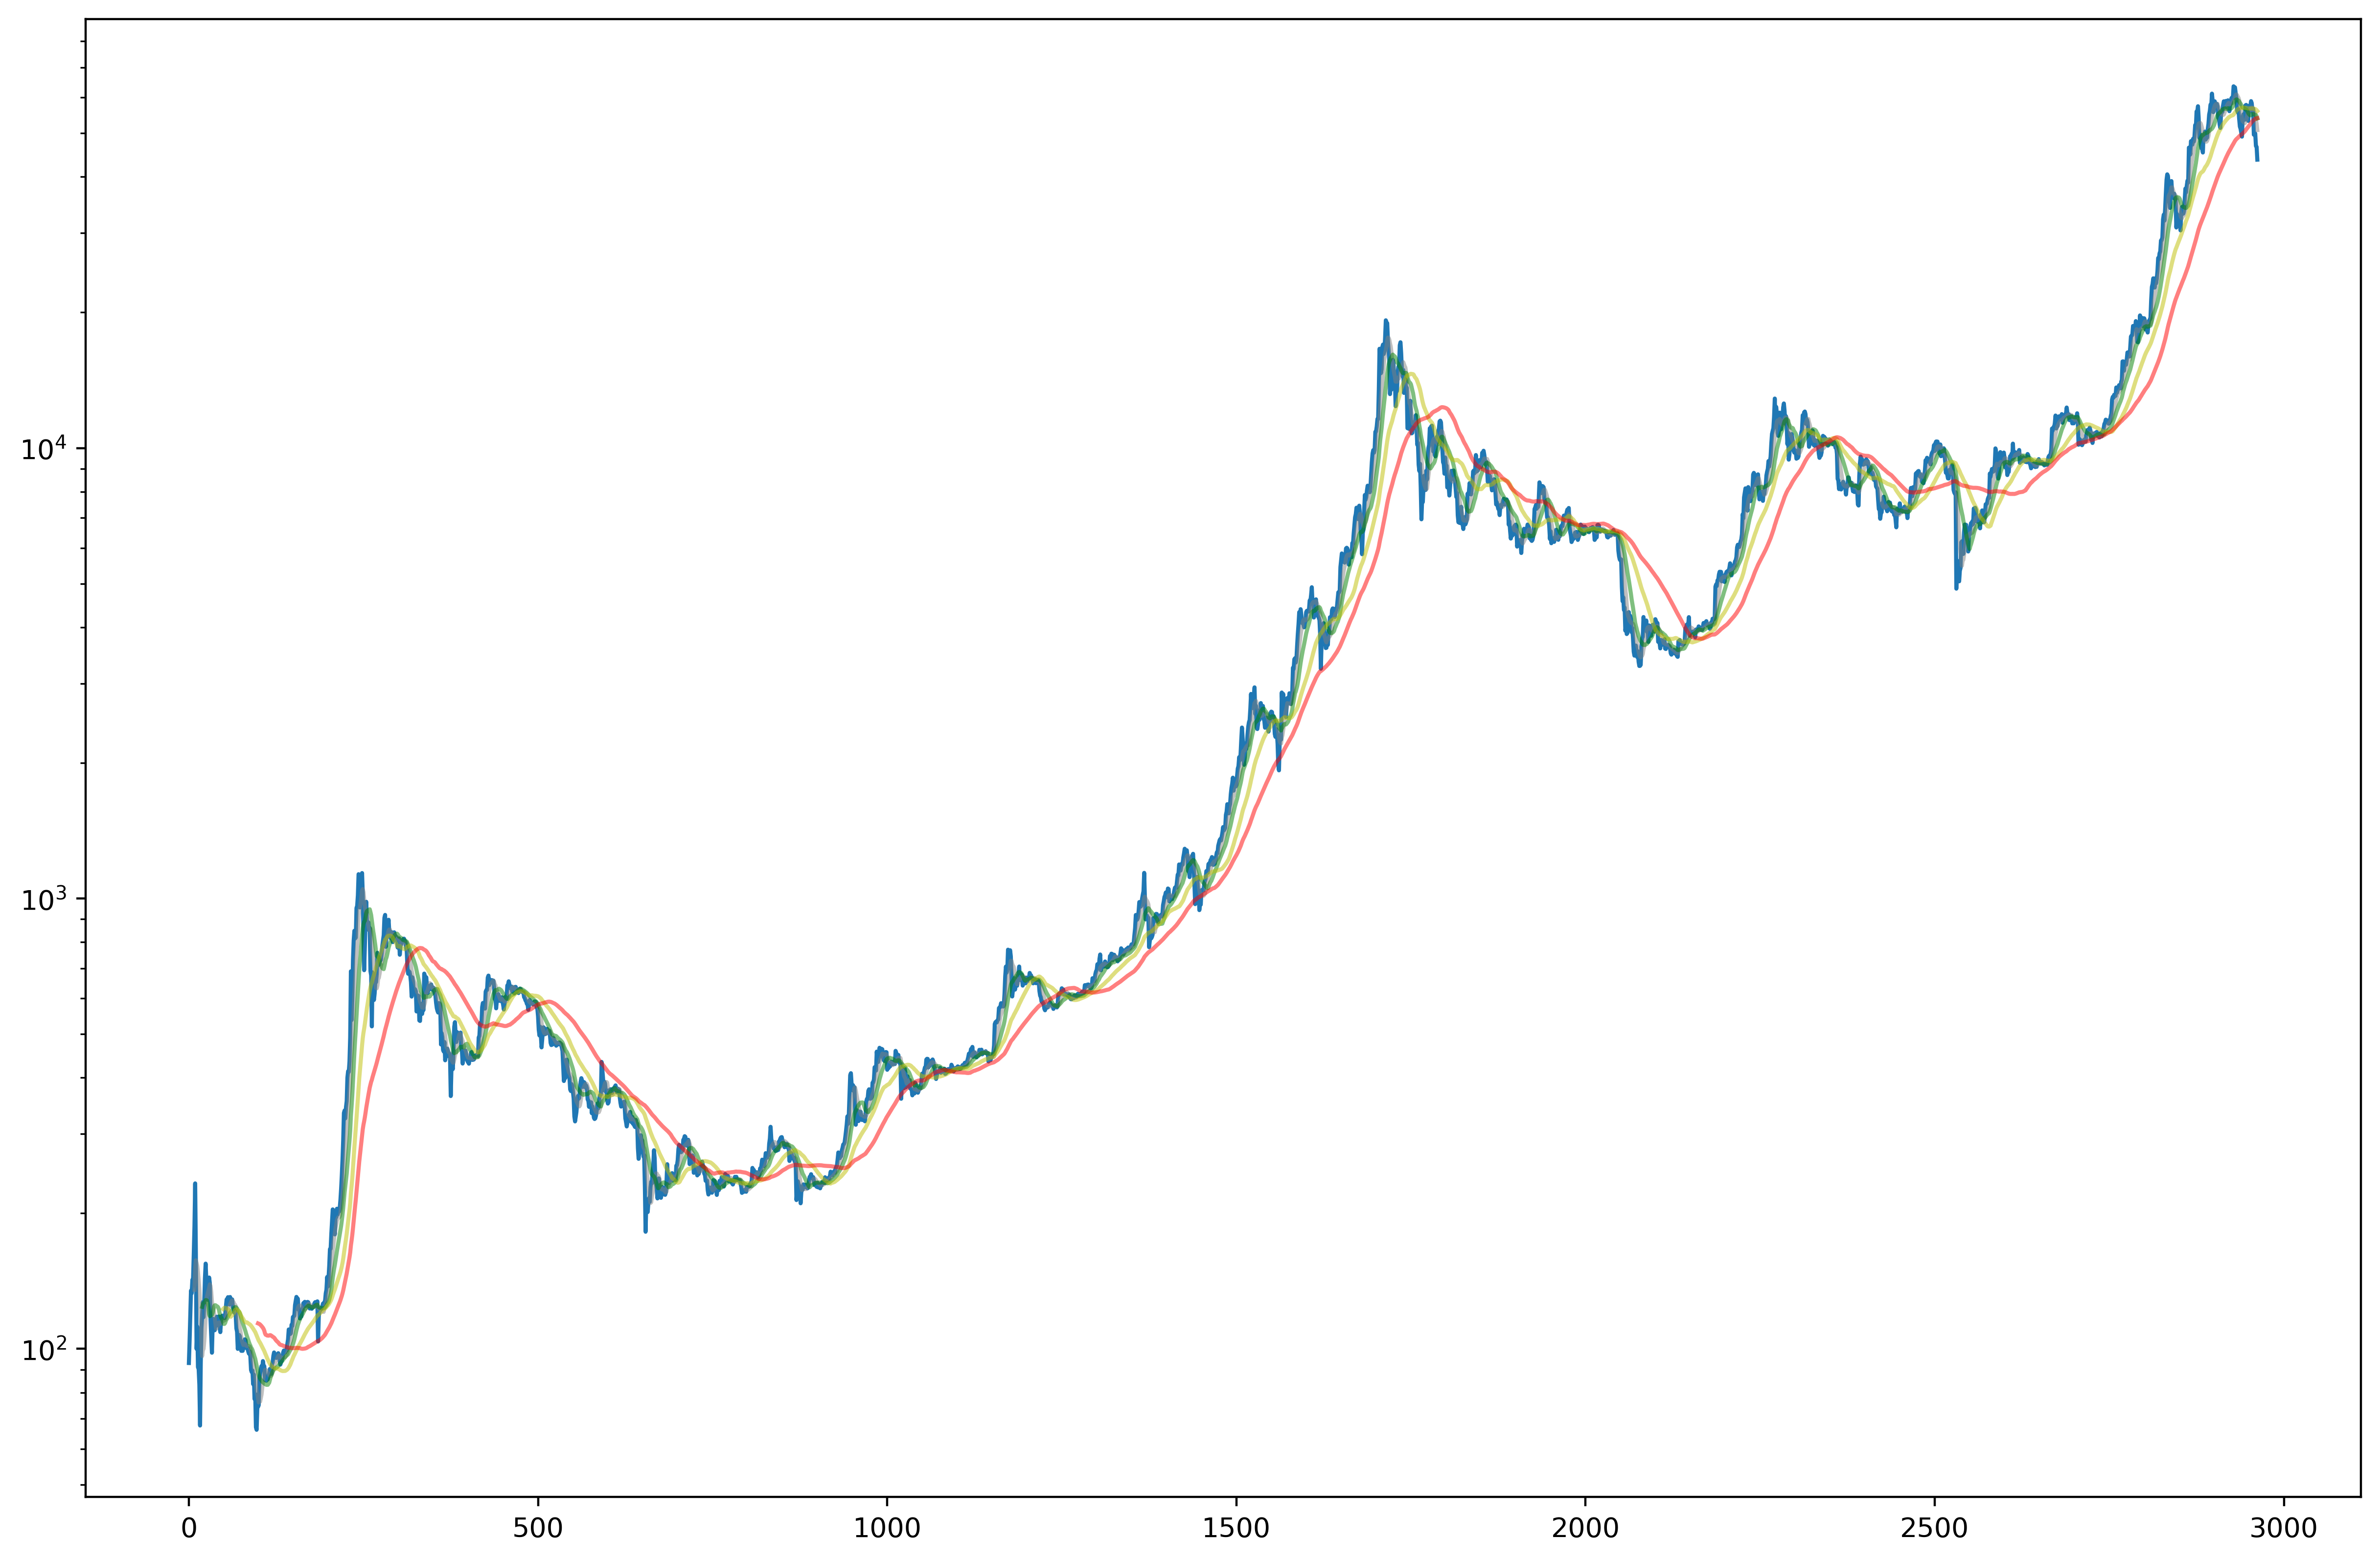

In [39]:
alpha=0.5
plt.figure(figsize=(15,10), dpi=400)
plt.plot(df_candles['CLOSE'])
plt.plot(SMA1, alpha=alpha, c='gray')
plt.plot(SMA2, alpha=alpha, c='g')
plt.plot(SMA3, alpha=alpha, c='y')
plt.plot(SMA4, alpha=alpha, c='r')
plt.yscale('log')
plt.show()

# Backtesting

In [40]:
#Add pad for price_watch
price_watch = [df_candles.iloc[0]['CLOSE']]

buy_prices = []
sell_prices = []
on_trade = False
pad = np.nan

for i in range(df_candles.shape[0]):
    current_i = i
    previous_i = i-1
    
    #Get closing price today
    price = df_candles.iloc[current_i]['CLOSE']
    #Get moving average for AOTS check
    SMA1_price = df_candles.iloc[current_i]['SMA1']
    SMA2_price = df_candles.iloc[current_i]['SMA2']
    SMA3_price = df_candles.iloc[current_i]['SMA3']
    SMA4_price = df_candles.iloc[current_i]['SMA4']
    
    #Append closing price today
    price_watch.append(price)
    #Get minimum and maximum from previous days (for fibonacci computation)
    minimum = min(price_watch[:-1])
    maximum = max(price_watch[:-1])
#    print(price)

    #SELLING
    #Check selling triggers if on trade:
    if on_trade:
        #If closing price is below fastest SMA (takes into account current)
        if price < SMA1_price:
            #Sell on closing price
            sell_prices.append(price)
            on_trade = False
            print(price, 'Sell')
            #Pad buying price
            buy_prices.append(pad)
            #Proceed with next iteration
            continue
    
    #BUYING
    # If there is more than one value in price_watch
    if len(price_watch[:-1]) > 1:
        #If Alignment of the Stars
        if SMA1_price > SMA2_price > SMA3_price > SMA4_price:
            #Append buying price for computation later
            buy_prices.append(price)
            #Trigger check for selling
            on_trade = True
            print(price, 'Buy')
            #Restart price_watch #FOR CHECKINGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG
            price_watch = [price]
            #Pad selling price
            sell_prices.append(pad)
            #Proceed with next iteration
            continue
    
                
    #Pad buying and selling price if no buying or selling happened
    buy_prices.append(pad)
    sell_prices.append(pad)
    

129.18 Buy
122.24 Sell
122.63 Buy
116.82 Sell
119.76 Buy
117.98 Sell
121.5 Buy
122.07 Sell
126.34 Buy
127.18 Buy
125.06 Buy
127.13 Buy
124.38 Sell
122.91 Buy
123.64 Sell
122.97 Buy
122.75 Sell
124.09 Buy
123.75 Sell
125.02 Buy
127.49 Buy
103.85 Sell
126.9 Buy
132.86 Buy
144.39 Buy
143.94 Buy
166.5 Buy
180.37 Buy
203.99 Buy
187.5 Buy
179.55 Sell
196.7 Buy
204.69 Buy
202.52 Buy
204.94 Buy
226.50499989999997 Buy
263.24 Buy
333.9 Buy
325.0 Buy
354.96 Buy
413.53499 Buy
434.52 Buy
689.0 Buy
599.12 Buy
806.3 Buy
815.0 Buy
952.0 Buy
1016.1 Buy
1119.52 Buy
955.0 Sell
1037.07 Buy
1138.5 Buy
1023.87 Sell
820.0 Buy
693.0 Sell
784.9 Buy
899.01 Sell
983.0 Buy
879.3 Sell
811.22 Buy
818.0 Sell
570.27 Buy
593.89 Sell
641.34 Buy
644.0 Buy
631.88 Buy
621.45 Sell
625.36 Buy
624.47 Sell
615.84 Buy
636.31 Buy
619.17 Sell
620.8 Buy
616.48 Sell
254.52 Buy
260.58 Buy
269.23 Buy
270.52 Buy
285.36 Buy
311.15 Buy
286.83 Buy
278.94 Sell
279.82 Buy
277.25 Sell
275.04 Buy
280.2 Sell
275.55 Buy
277.99 Sell
295.23 Buy

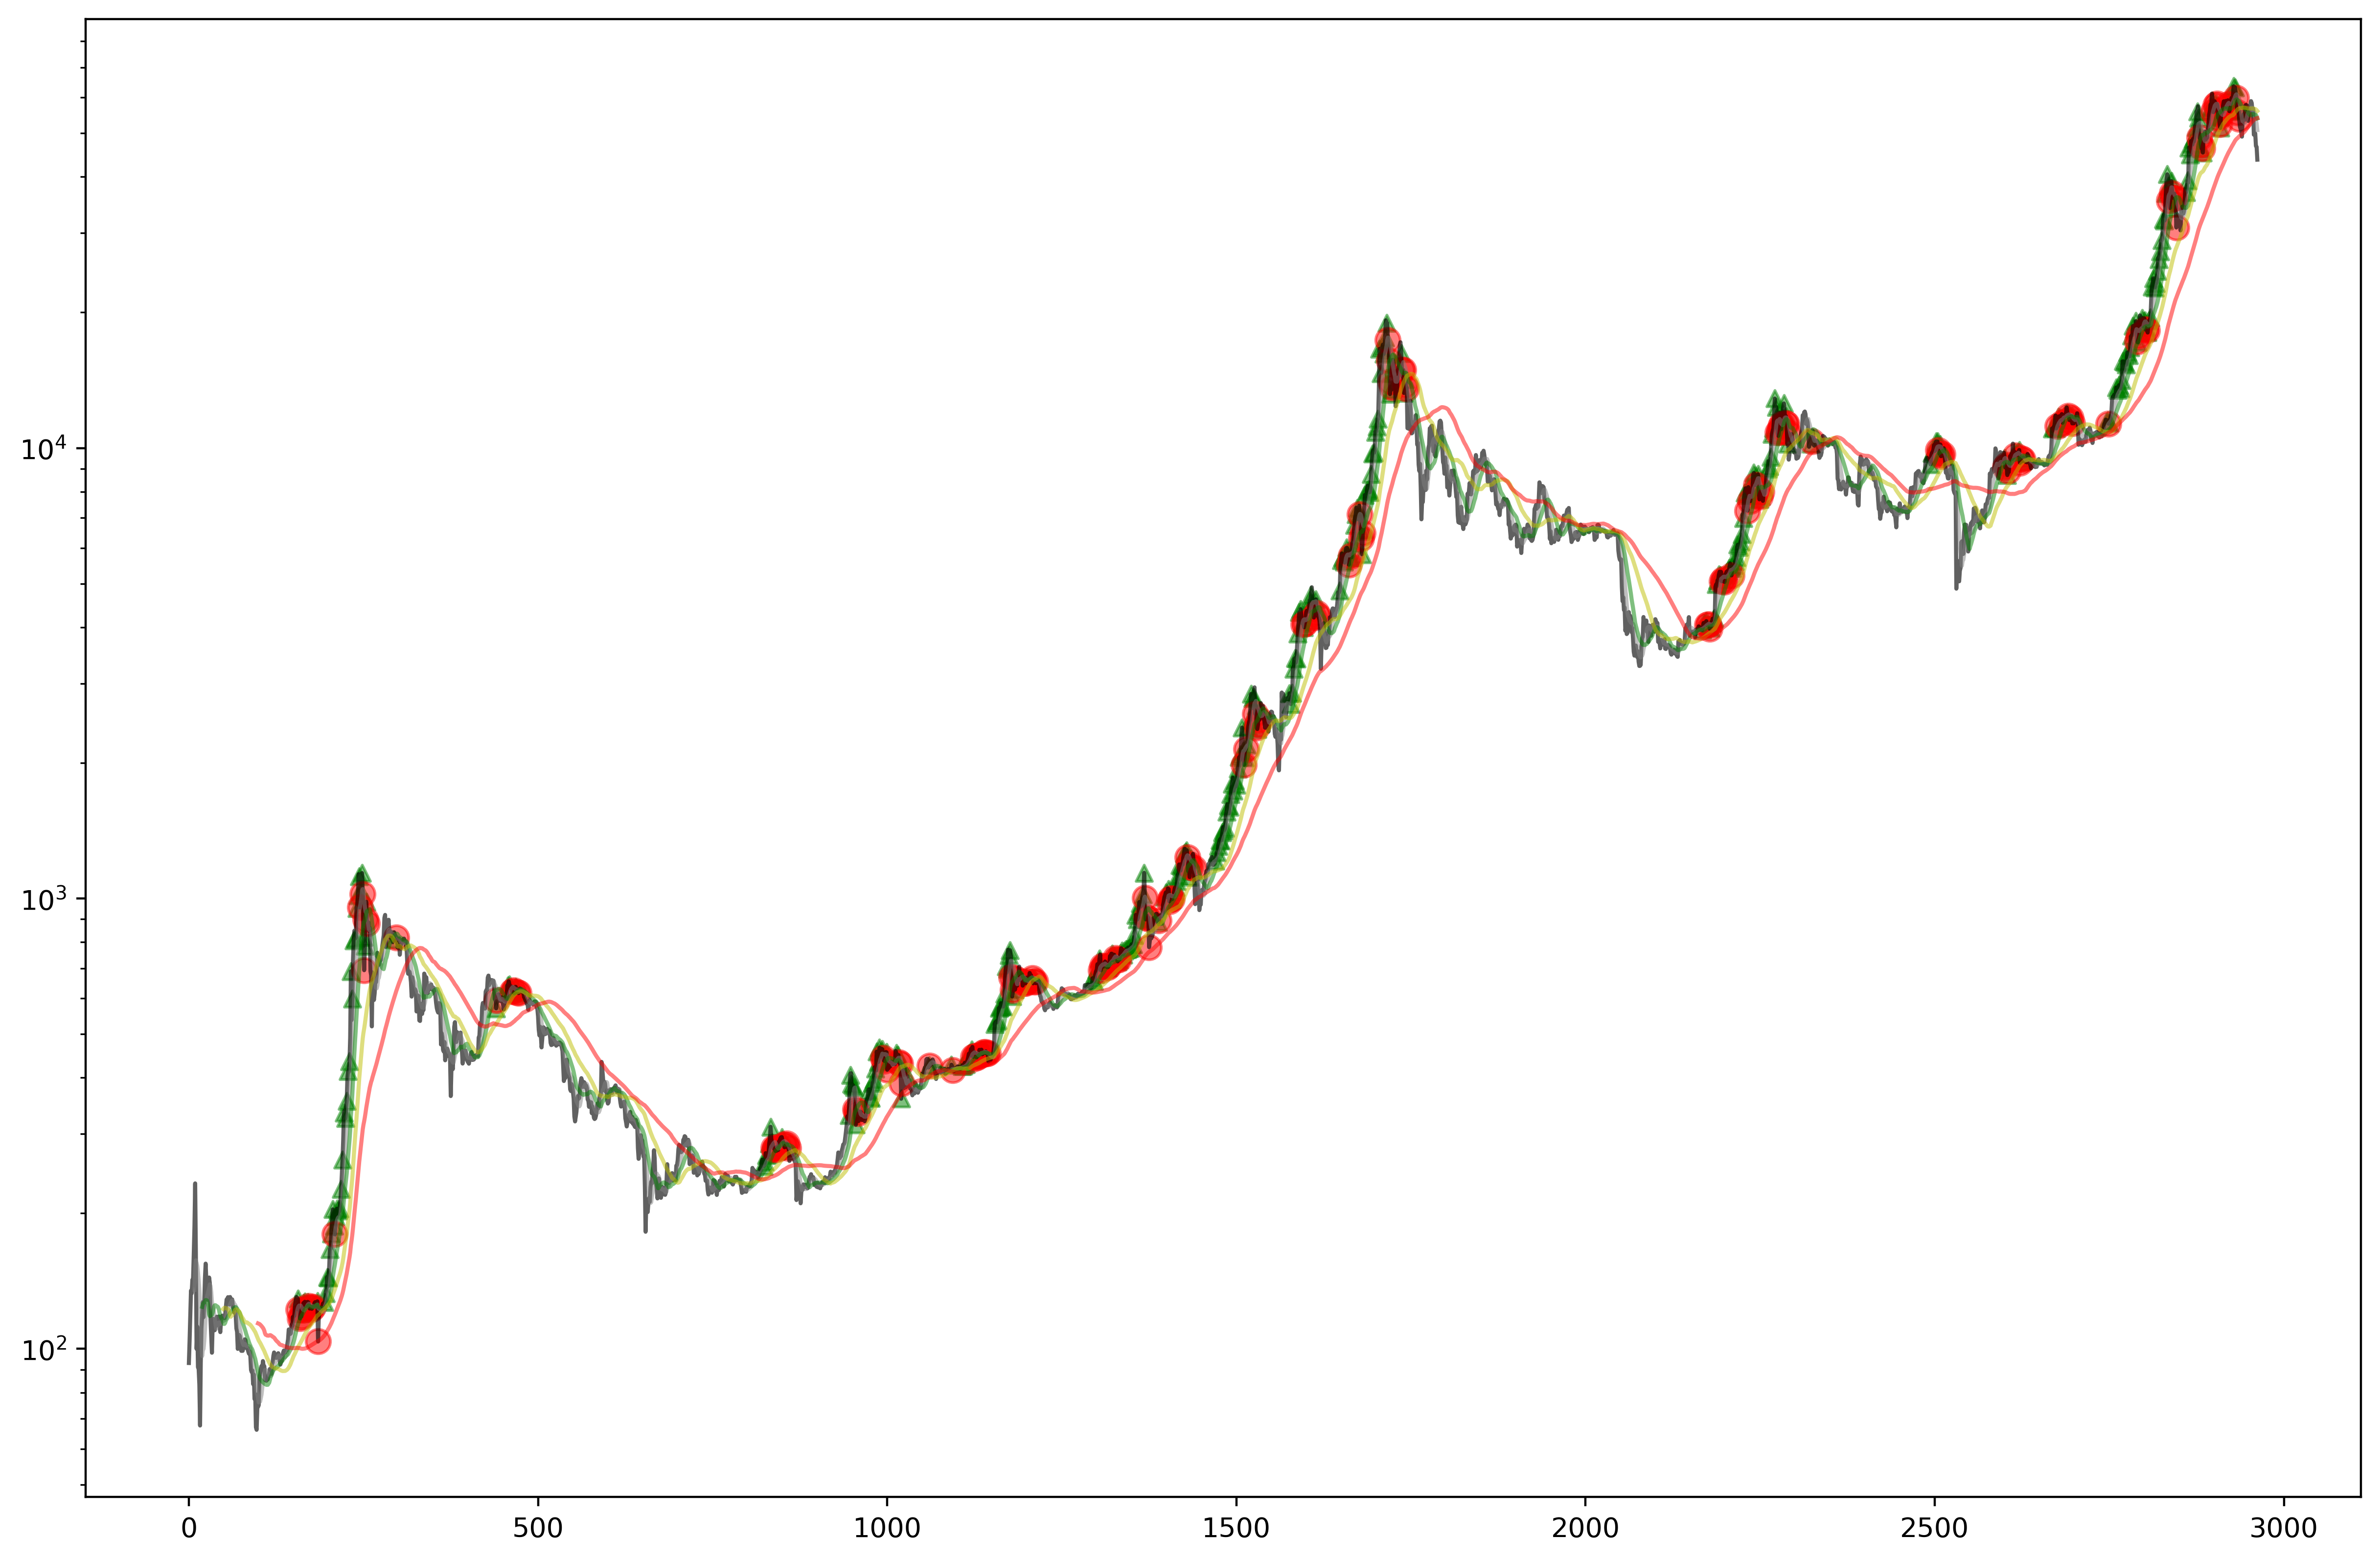

In [41]:
alpha=0.5
plt.figure(figsize=(15,10), dpi=400)
#plt.scatter(range(len(sell_prices)), sell_prices,c='r', marker='o', alpha=alpha, s=80)
plt.scatter(range(len(buy_prices)), buy_prices,c='g', marker='^', alpha=alpha)
plt.plot(df_candles['CLOSE'], c='k', alpha=alpha*1.25)
plt.plot(SMA1, alpha=alpha, c='gray')
plt.plot(SMA2, alpha=alpha, c='g')
plt.plot(SMA3, alpha=alpha, c='y')
plt.plot(SMA4, alpha=alpha, c='r')
plt.scatter(range(len(sell_prices)), sell_prices,c='r', marker='o', alpha=alpha, s=80)
plt.yscale('log')
plt.show()

# Gain calculation

In [42]:
#Turn buy and sell prices into arrays
sell_prices_array = np.array(sell_prices)
buy_prices_array = np.array(buy_prices)

#Convert to DataFrame
df_gains = pd.DataFrame([sell_prices_array, buy_prices_array]).T
#Only select values with non-zeros as sum (i.e. not padded with zeroes)
df_gains = df_gains[df_gains.sum(axis=1) > 0]
#Rename columns
df_gains.columns = ['sell_price', 'buy_price']
#Replace padding with np.nan
df_gains = df_gains.replace(0, np.nan)
#Back fill sell prices
df_gains['sell_price'] = df_gains['sell_price'].fillna(method='bfill')
#Drop columns with no buy price
df_gains = df_gains.dropna(how='any', axis=0)

In [43]:
#Compute percentage gains
df_gains['percent_gain'] = 100*(df_gains['sell_price'] - df_gains['buy_price']) / df_gains['buy_price']

In [44]:
df_gains['percent_gain'].describe()

count    452.000000
mean      14.103905
std       47.209759
min      -18.542631
25%       -3.021757
50%        0.567328
75%       13.698230
max      385.510930
Name: percent_gain, dtype: float64

<AxesSubplot:ylabel='Frequency'>

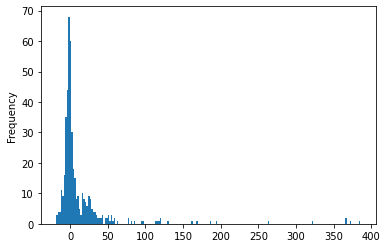

In [45]:
df_gains['percent_gain'].plot.hist(bins=200)

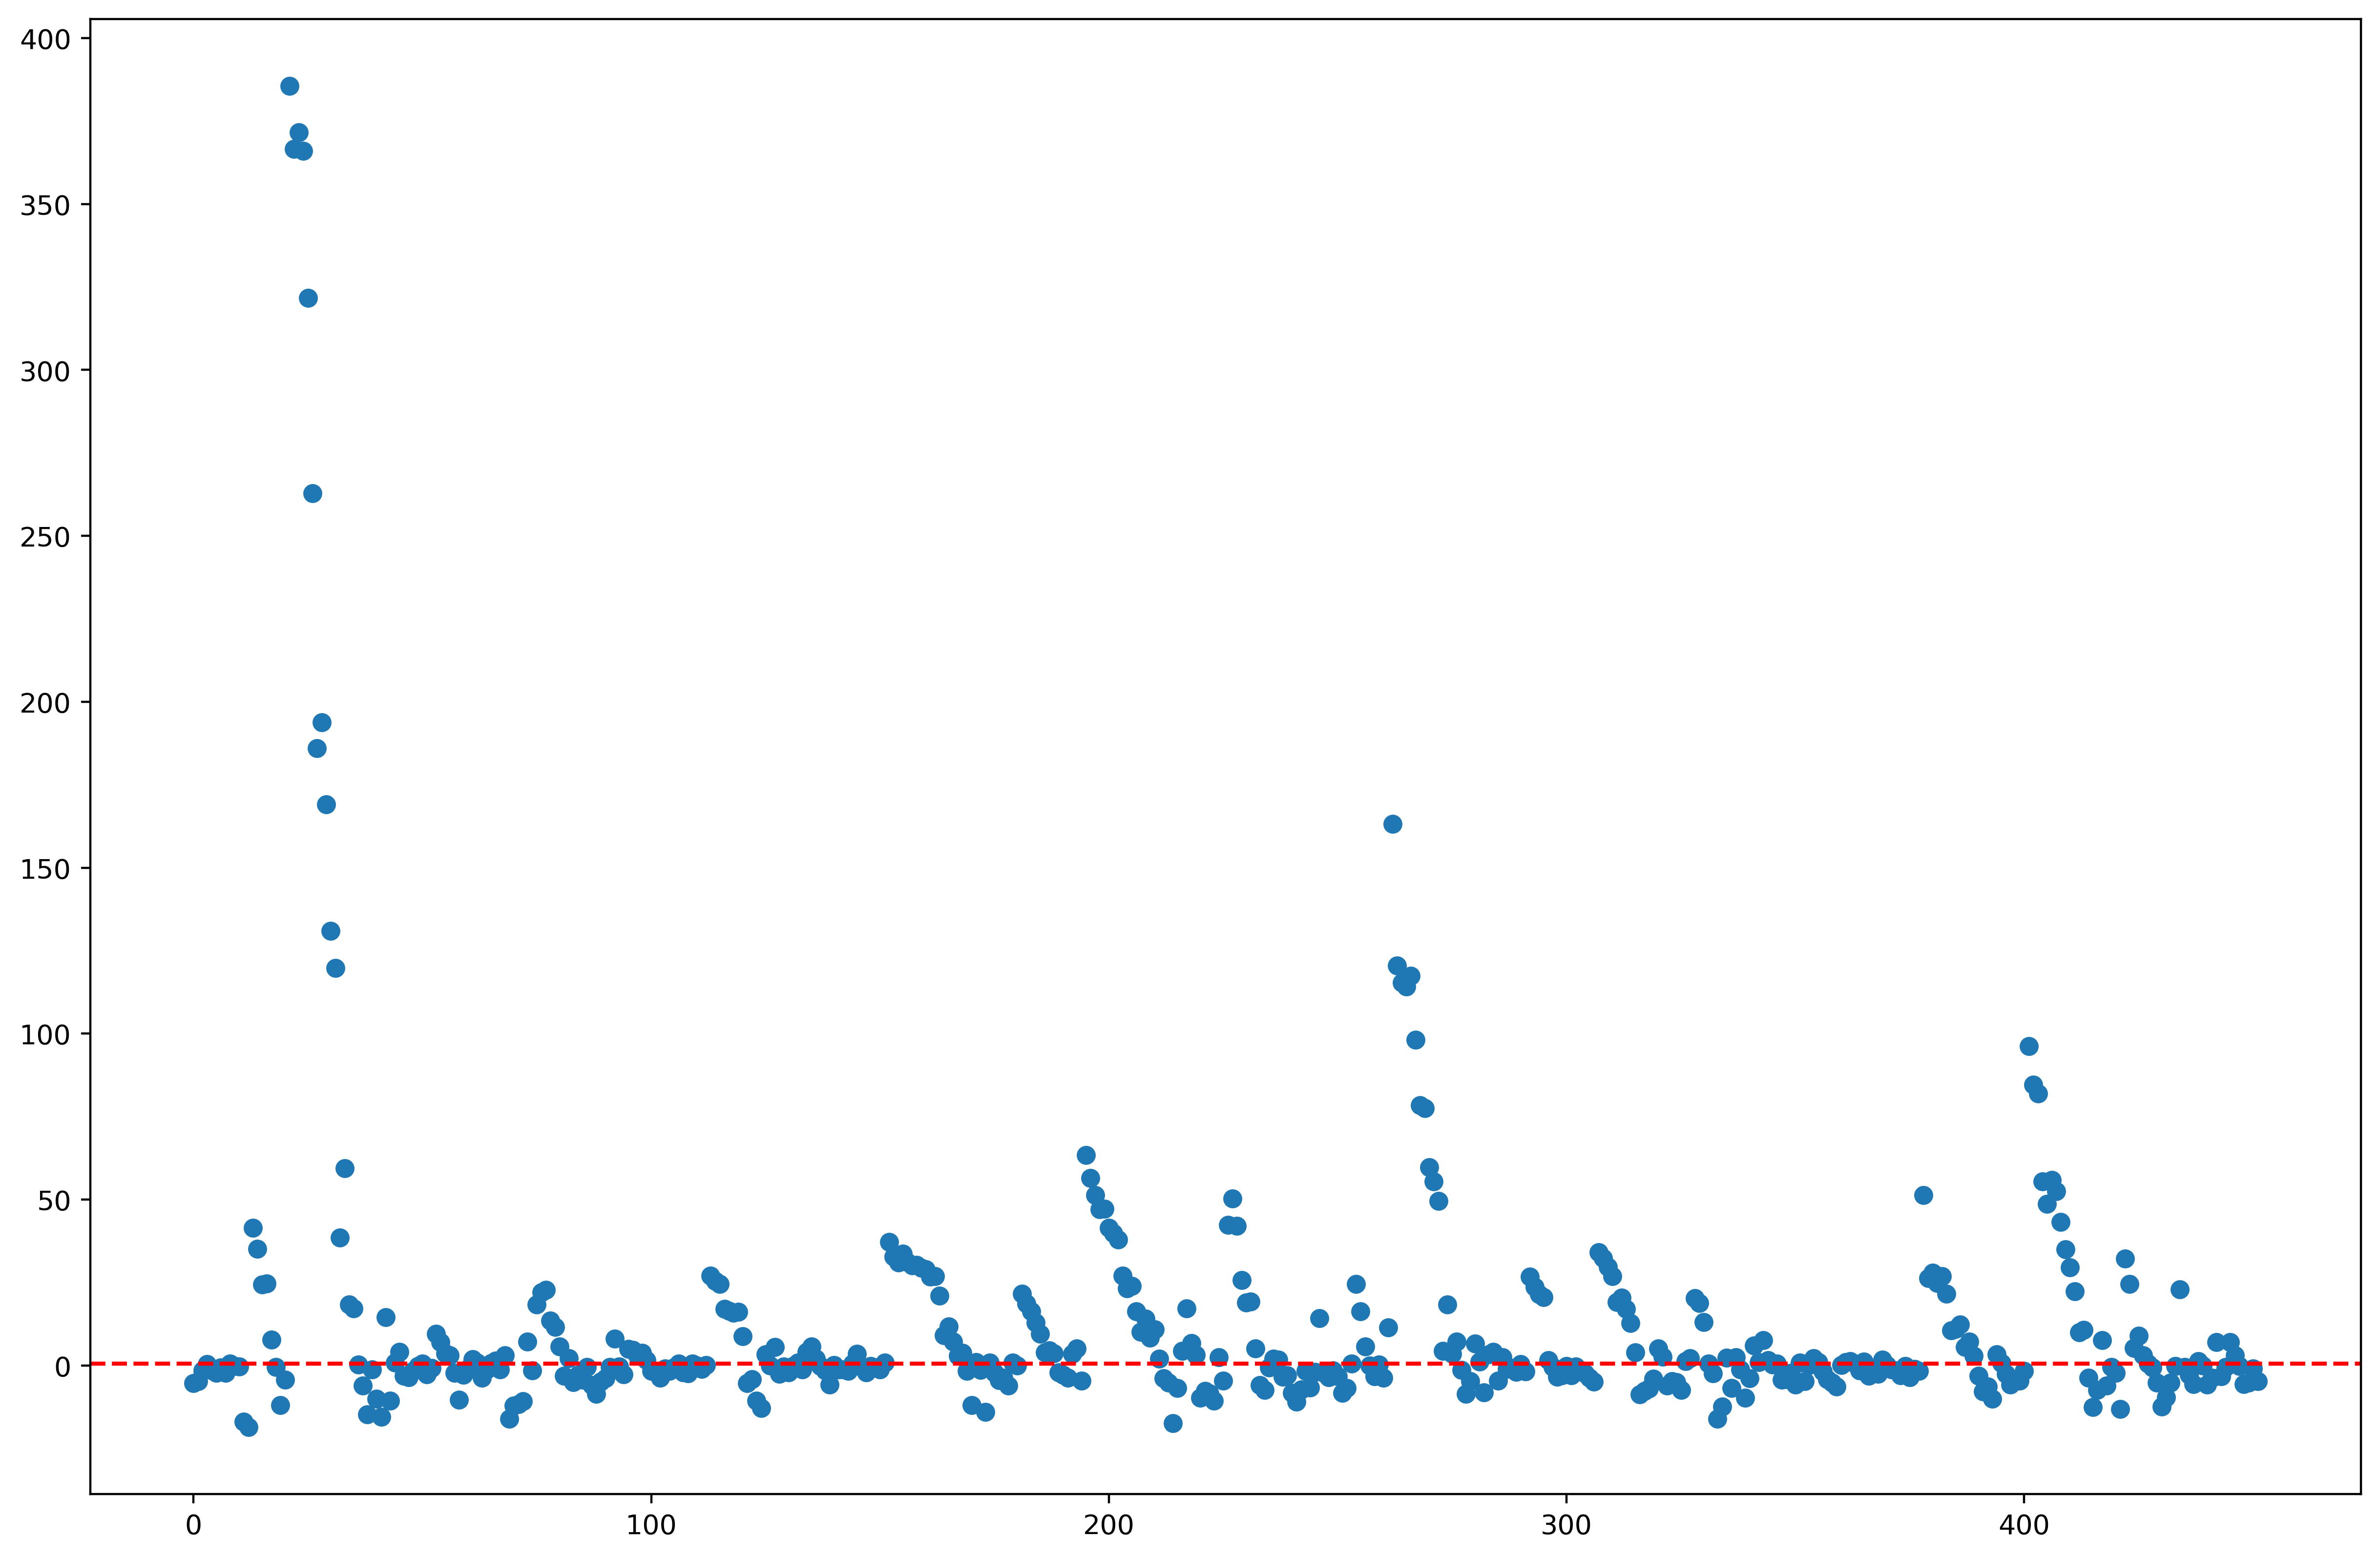

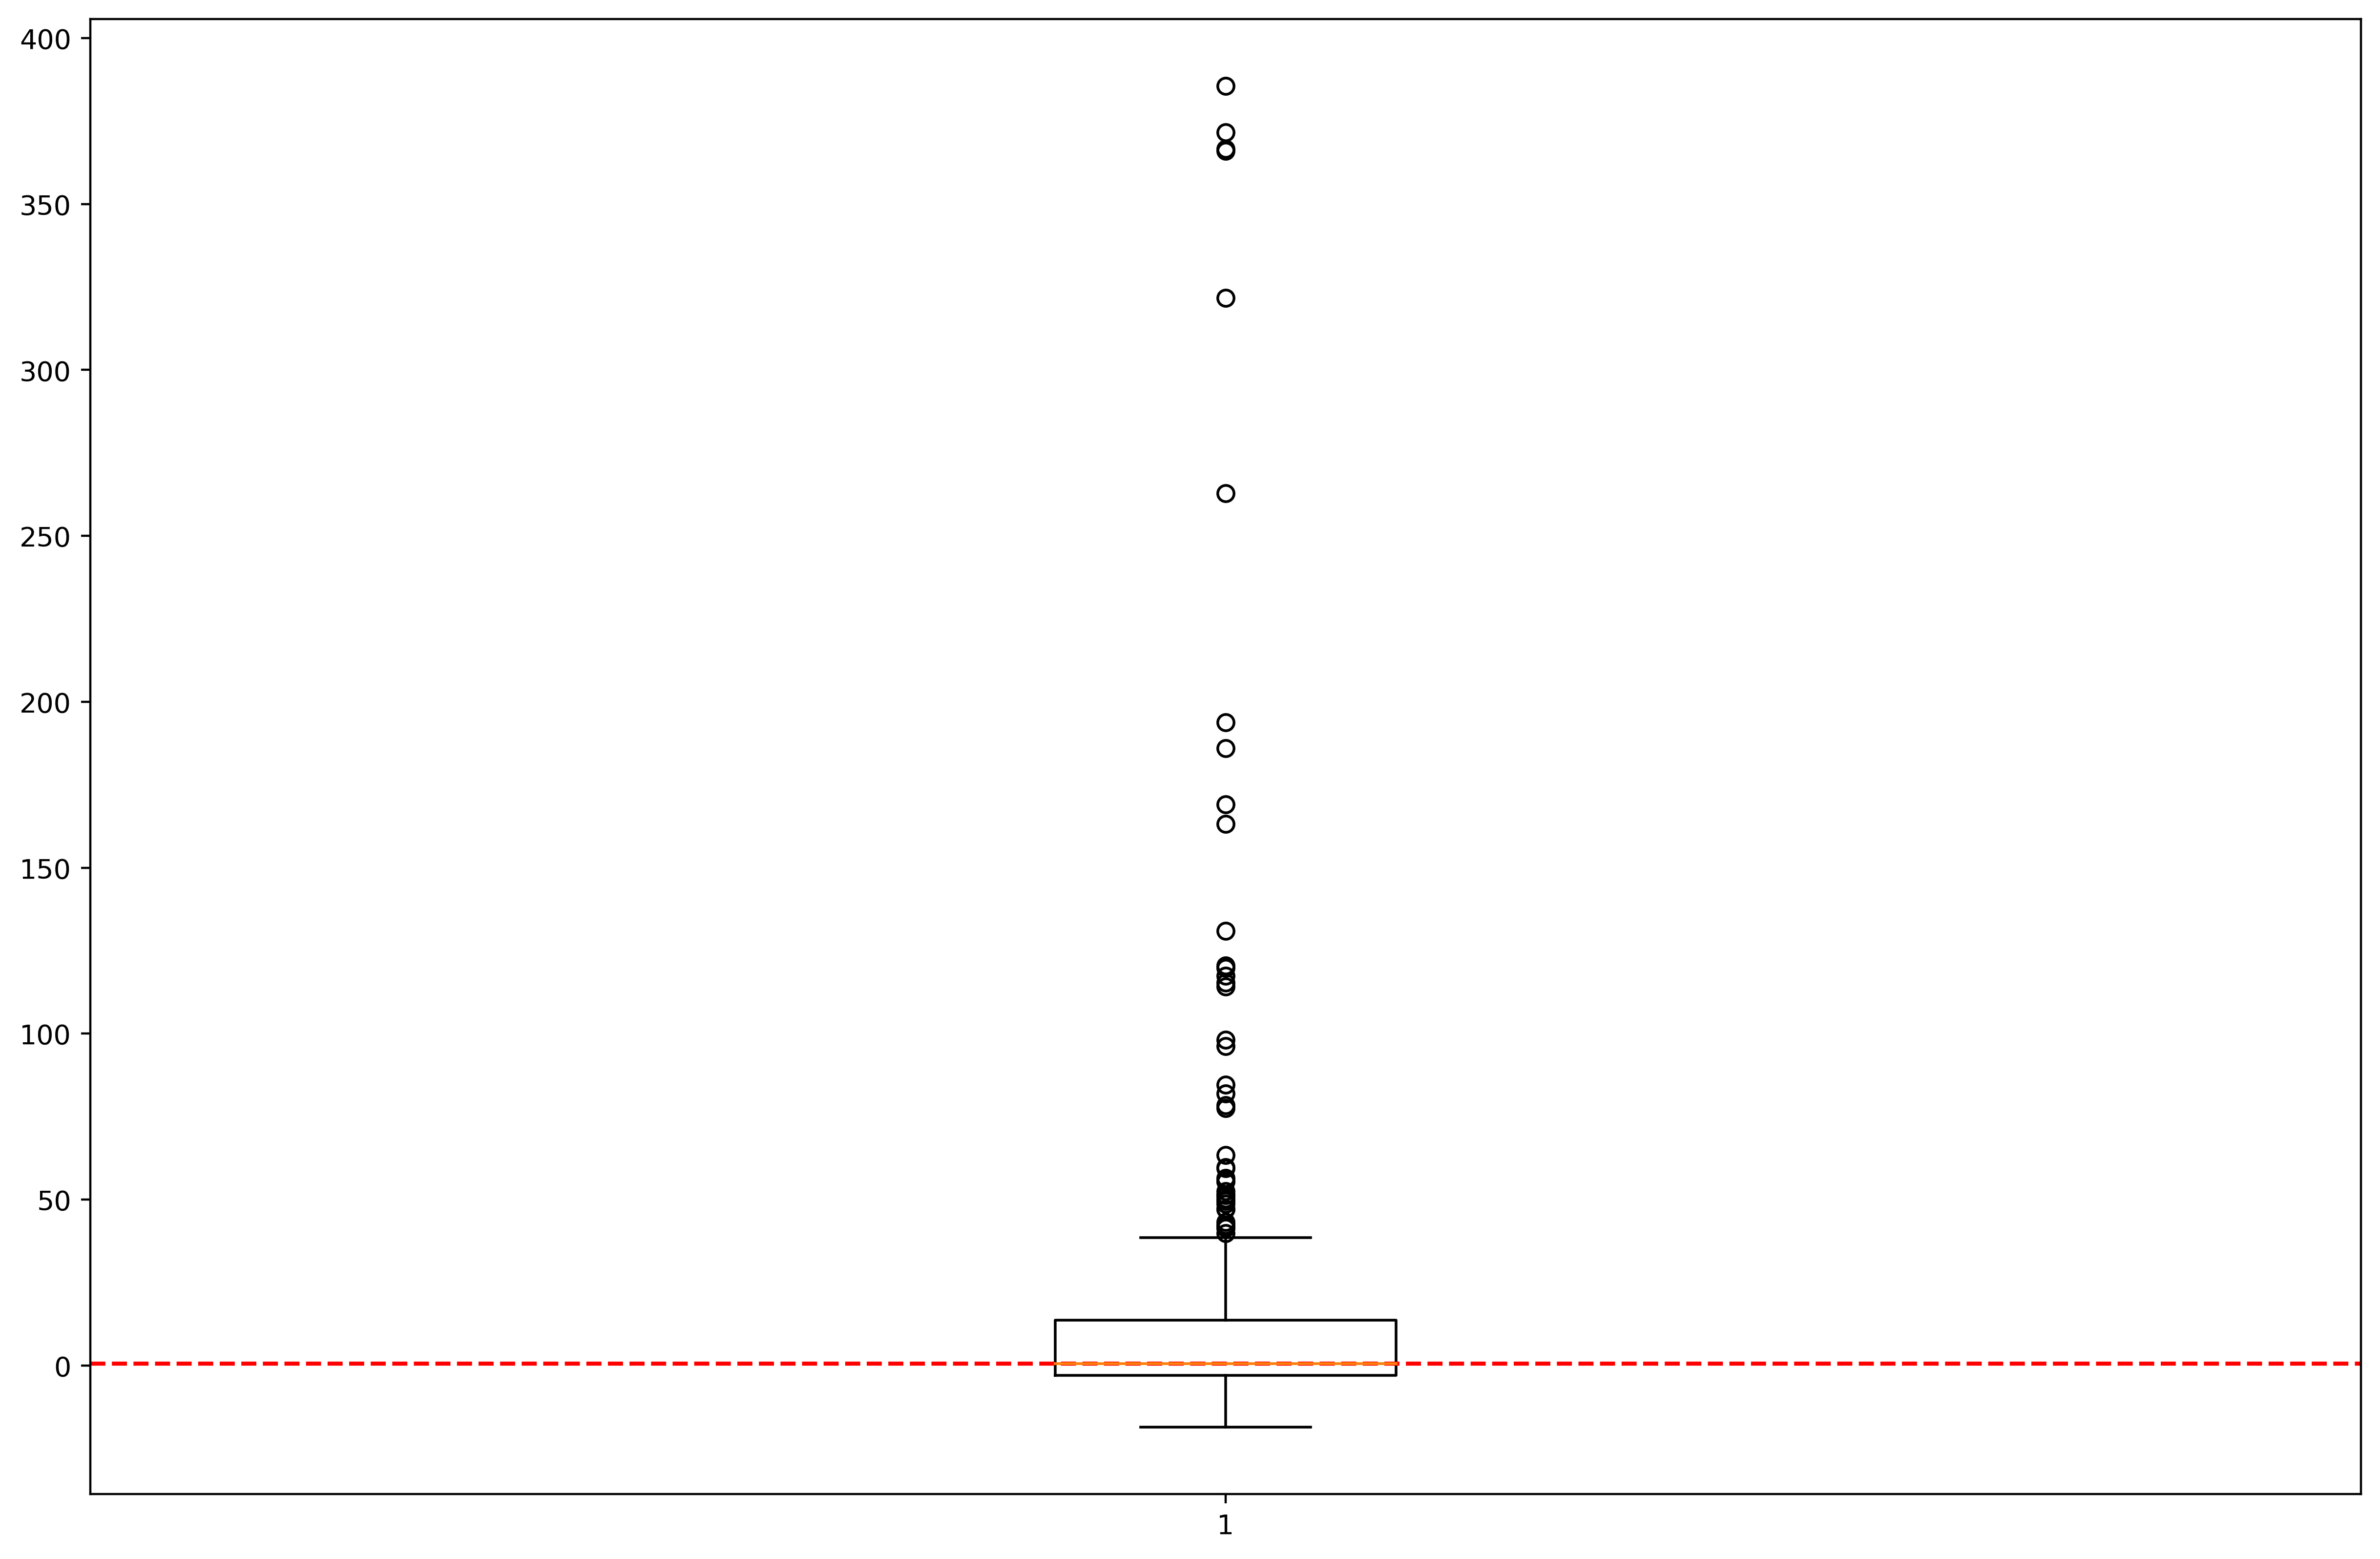

In [46]:
y = df_gains['percent_gain']
x = range(len(y))

plt.figure(figsize=(15,10), dpi=400)
plt.scatter(x, y)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.show()

plt.figure(figsize=(15,10), dpi=400)
plt.boxplot(y)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.show()

In [47]:
percent_wins = []
percent_losses = []
for i in df_gains['percent_gain']:
    if i > 0:
        percent_wins.append(i)
    else:
        percent_losses.append(i)
       
print('Win Count: ', len(percent_wins))
print('Average Win Percent', np.mean(percent_wins))
print('Lose Count: ', len(percent_losses))
print('Average Lose Percent', np.mean(percent_losses))
print('Win Rate: ', (len(percent_wins))/(len(percent_wins)+len(percent_losses)))
        

Win Count:  243
Average Win Percent 30.06741600241372
Lose Count:  209
Average Lose Percent -4.456541627176702
Win Rate:  0.5376106194690266
